In [ ]:
#!unzip /content/drive/MyDrive/thesis/flicker8k/archive_IC.zip -d /content/drive/MyDrive/thesis/flicker8k/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-6ma5qj3l
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-6ma5qj3l
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=2c7a7710ee6c56e4cdaa06d49b8175ac0440927fd3e1fbaf66d179338afadf8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-6wv79h2t/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fee5
Successfully built pycocoevalcap


In [ ]:
!pip install --upgrade bleu

  Preparing metadata (setup.py) ... done
  Created wheel for bleu: filename=bleu-0.3-py3-none-any.whl size=5781 sha256=afab9e5f10b4e70f66dd37597cf52c38416bc90990626419d6fbc0cfa489268e
  Stored in directory: /root/.cache/pip/wheels/c6/d8/d1/009abe01b8b2c6a14c62d197b510b3cc1076014c22d712c5ce
Successfully built bleu


# Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import zipfile
from tensorflow.keras.applications.resnet50 import ResNet50
import re
import tqdm
import pickle
from bleu import list_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.util import ngrams
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
from collections import defaultdict
import json
import time
import itertools
import os, os.path
import math

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab
import random
from shutil import copyfile
import cv2
import time
from PIL import Image

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

In [ ]:
from gym import Env
from gym import spaces

In [ ]:
tref = ['a man climbing a mountain',
 'a man climbs a mountain',
 'a man is climbing a side of a mountain',
 'a shirtless man climbs up a steep mountain',
 'a young white man is climbing a mountain with a rope as a guide']

hyp = 'a man climbs a cliff face'
sentence_bleu(tref, hyp)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6342834010525136

# Globals

## Variables

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from shutil import copyfile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the paths for the Flicker8k dataset
dataDir = '/content/drive/MyDrive/thesis/flicker8k'
project_path = '/content/drive/MyDrive/thesis'

pictures_dir_path = dataDir + '/Images'

train_dir_path = dataDir + '/train'
test_dir_path = dataDir + '/test'
# Create the dataframe for the dataset
dataset = pd.DataFrame(columns = ['id', 'is_training', 'captions', 'url'])
train_df_path = os.path.join(project_path,'train_data_f.csv')
test_df_path = os.path.join(project_path,'test_data_f.csv')

# Set the parameters for the model
embedding_dim = 2048
max_length = 16
num_words = 2075

# Define the Data class
class Data:
    def __init__(self, id, captions):
        self.id = id
        self.captions = captions
        self.image = img_id_to_data(self.id)
    def show_info(self):
        show_img_by_file(pictures_dir_path + "/" + img_id_to_url(self.id))
        print(self.captions)

def show_img_by_file(file_address):
    plt.imshow(mpimg.imread(file_address))
    plt.axis('off')
    plt.show()

def img_id_to_url(img_id, img_type='jpg'):
  # print("url :",str(img_id) + '.' + img_type)
  return str(img_id) + '.' + img_type

def img_id_to_data(img_id, img_height=224, img_width=224):
    url = img_id_to_url(img_id)
    img_path = pictures_dir_path+'/'+url
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_height, img_width))
    input_arr = np.array(img)
    input_arr = input_arr.astype('float32') / 255.0
    return input_arr

def show_image_by_data(img):
    plt.imshow(img)
    plt.show()

def remove_startseq_endseq(captions):
    captions = [caption.replace('startseq ', '') for caption in captions]
    captions = [caption.replace(' endseq', '') for caption in captions]
    return captions



In [ ]:
# Train/Test Split

def split_data(source_dir, train_dir, test_dir, split_size):
    items = os.listdir(source_dir)
    items = random.sample(items, len(items))
    for i in range(len(items)):
        if i < split_size * len(items):
            copyfile(os.path.join(source_dir, items[i]), os.path.join(train_dir, items[i]))
        else:
            copyfile(os.path.join(source_dir, items[i]), os.path.join(test_dir, items[i]))
# Run the line below just for the first time
# split_data(pictures_dir_path, train_dir_path, test_dir_path, 0.8)
print(len(os.listdir(train_dir_path)), len(os.listdir(test_dir_path)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


8073 4555


In [ ]:

# Load Images and Captions

def img_url_to_id(img_url, img_type='jpg'):
  # print('img_url :',img_url)
  # print('slice :',img_url[:-len(img_type)-1])
  return img_url[:-len(img_type)-1]


def load_img_captions(img_id):
    captions = []
    with open(os.path.join(project_path,'flicker8k/captions.txt'), 'r') as f:
        for line in f:
            if str(img_id) in line.split(',')[0]:
                captions.append(line.split(',')[1])
    return captions

def load_imgs_and_caps(source_dir, is_training):
    images = os.listdir(source_dir)
    counter = 0
    total_ids = []
    total_is_trainings = []
    total_rs = []
    total_gs = []
    total_bs = []
    total_caps = []
    total_urls = []
    for img_url in images:
        # Assuming that the image URLs are in the format of "image_id.jpg"
        img_id = img_url.split(".")[0]
        captions = load_img_captions(img_id) # Assuming this function loads the captions for the image with ID "img_id"
        total_ids.append(img_id)
        total_is_trainings.append(is_training)

        t1 = time.time()
        img_data = img_id_to_data(img_id) # Assuming this function loads the image data for the image with ID "img_id"

        total_rs.append(img_data[0])
        total_gs.append(img_data[1])
        total_bs.append(img_data[2])
        total_caps.append(captions)
        total_urls.append(img_url)

        t3 = time.time()
        if counter % 200 == 0:
            print(f'{counter} images loaded')
        counter += 1
        t3 = time.time()
    return pd.DataFrame({
        "id": total_ids,
        "is_training": total_is_trainings,
        'r': total_rs,
        'g': total_gs,
        'b': total_bs,
        'captions': total_caps,
        'url': total_urls
    })

# train_df = load_imgs_and_caps(train_dir_path, True)
# test_df = load_imgs_and_caps(test_dir_path, False)
# train_df.to_csv(os.path.join(project_path,"train_data_f.csv"), sep=',')
# test_df.to_csv(os.path.join(project_path,"test_data_f.csv"), sep=',')

## Read data from dataframes

In [ ]:
train_df = pd.read_csv(os.path.join(project_path, train_df_path))
test_df = pd.read_csv(os.path.join(project_path,test_df_path))

### Delete extra rows

In [ ]:
train_df = train_df.drop(columns=['Unnamed: 0'])
test_df = test_df.drop(columns=['Unnamed: 0'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Get Image data

In [ ]:
"""
This code is taking a string as input, which represents an array of numbers. It is then editing the
string by removing certain characters (e.g. "[", "\n", "]") and replacing multiple spaces with a
single space. Then it converts the edited string into an array of numbers using the numpy function
np.fromstring() . Finally it reshape the array of numbers to a desired shape (default is [224,224])
and return
the reshaped array.
"""
def string_to_array(raw_str, shape = [224,224]):

  edited = raw_str.replace('[', '')
  edited = edited.replace('\n','')
  edited = edited.replace(']', '')
  edited = re.sub(' +', ' ', edited)
  edited = np.fromstring(edited, dtype=float, sep=' ')
  return edited.reshape(shape)
  # print(edited)
print('done')

done


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# string_to_array(train_df['r'][0])
"""
his code defines a function all_data() which takes a list of image ids as input. It then creates
an empty list data and a counter variable counter. It then iterates over the ids in the input list,
and for each id, it calls the function img_id_to_data() with the id as input, and appends the returned
data to the data list. Every 200 iterations, it prints the message of how many images have been loaded.
Finally,
it returns the data list.
"""
def all_data(ids):
  data = []
  counter = 0
  for id in ids:
    data.append(img_id_to_data(id))
    if counter % 200 == 0:
      print(f'{counter} images loaded')
    counter += 1
  return data

## Model 1

In [ ]:
"""
This code is a function that preprocesses an image. It loads an image from a file path,
resizes it to 299x299 pixels, converts it to a numpy array, adds an extra dimension to the array,
and applies preprocessing to the image using the preprocess_input() function from the inception_v3
module in TensorFlow's Keras library. The preprocessing is specific to the Inception V3 model so that
the image is ready to be passed through the model.

"""
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = tf.keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
input1 = tf.keras.applications.InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
pt_model = tf.keras.models.Model(input1.input, input1.layers[-2].output)

96112376/96112376 [==============================] - 5s 0us/step


In [ ]:
# Function to encode a given image into a vector of size (2048, )
"""
This code is defining a function called "encode" that takes in an image as an input.
It first runs the image through a preprocessing step, which includes loading the image,
converting it to a numpy array, adding an extra dimension, and using a preprocessing function from a
module called "inception_v3" to adjust the image.

After the image is preprocessed, the function gets the "encoding vector" for the image by running the
preprocessed image through a model called "pt_model" and predicting the encoding vector.

The encoding vector is then reshaped so that its shape is (2048, ) instead of (1, 2048) before it is
returned by the function.
"""
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = pt_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
"""
Run the code below for the first run
"""
t_encoding = {}
# for url in tqdm.tqdm(train_df['url']):
#   t_encoding[url] = encode(pictures_dir_path+'/'+url)

In [ ]:
"""
Run the code below for the first run
"""
# Save the features in the images1 pickle file
path_enco_train = project_path+'/'
# with open(os.path.join(path_enco_train,"train_images_f.pkl"), "wb") as t_encoded_pickle:
#   pickle.dump(t_encoding, t_encoded_pickle)

### test features

In [ ]:
"""
Run the code below for the first run
"""
encoding = {}
# for url in tqdm.tqdm(test_df['url']):
#   encoding[url] = encode(pictures_dir_path+'/'+url)



In [ ]:
"""
Run the code below for the first run
"""
# Save the features in the images1 pickle file
# with open(os.path.join(project_path,"test_images_f.pkl"), "wb") as encoded_pickle:
#   pickle.dump(encoding, encoded_pickle)

'\nRun the code below for the first run\n'

In [ ]:
# print(encoding['000000000139.jpg'])

### load features

In [ ]:
features = pickle.load(open(os.path.join(project_path,"train_images_f.pkl"), "rb"))

t_features = pickle.load(open(os.path.join(project_path, "test_images_f.pkl"), "rb"))

In [ ]:
# testing
#print(features['667626_18933d713e.jpg'])

# Captions Processing

## Build Vocabularies

### Load captions (endseq)

In [ ]:
"""
This code defines a function called add_start_and_endseq that takes in a string as its input.
The function concatenates the string "startseq" to the beginning of the input string, and
concatenates "endseq" to the end of the input string, with a space in between. The function
then returns the
resulting concatenated string.
"""
def add_start_and_endseq(input_str):
  return 'startseq' + ' ' + input_str + ' ' + 'endseq'

#Load caption and add endseq at the end of them
"""
This code creates a dictionary of captions for a set of images. The captions are obtained from the
input_coco_caps object, which is assumed to be a COCO object with captions. The images are located
in the directory specified by the dir_path variable (default is train_dir_path). For each image,
the annotations associated with the image are retrieved, and for each annotation, the caption is
modified by adding 'startseq' at the beginning and 'endseq' at the end, and then added to the
captions_dic dictionary, with the image_id as the key. If the image_id already exists in the
dictionary, the new caption is added to the list of captions associated with that image_id.
"""
def create_captions_dic(inp_captions_file, dir_path = train_dir_path):
  captions_dic = {}
  lst = []
  ct =0
  images = os.listdir(dir_path)
  with open(inp_captions_file, 'r') as file:
    for line in file:

      data = line.strip().split(',')
      img_url = data[0]
      if img_url in images:
        caption = add_start_and_endseq(data[1])
        if img_url not in captions_dic:
          captions_dic[img_url] = [caption]
        else:
          captions_dic[img_url].append(caption)
      ct+=1
  return captions_dic

In [ ]:
# train_caps = create_captions_dic(coco_caps)
captions_file = os.path.join(project_path,'flicker8k/captions.txt')
train_caps = create_captions_dic(captions_file)





In [ ]:
#print(train_caps['667626_18933d713e.jpg'])


In [ ]:
test_caps = create_captions_dic(captions_file, dir_path=test_dir_path)

#Test
print(len(test_caps))


4555


### Tokenization

#### Making a list of all captions

In [ ]:
len(train_caps.values())
flat_train_caps = [cap for sublist in train_caps.values() for cap in sublist]

In [ ]:
print(len(flat_train_caps))
print(len(train_caps.values()))

40365
8073


#### Tokenizing captions

In [ ]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(oov_token='OOV',
                      filters= "!'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n",
                      num_words=num_words)

# Generate the word index dictionary
tokenizer.fit_on_texts(flat_train_caps)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'OOV': 1, 'a': 2, 'startseq': 3, 'endseq': 4, 'in': 5, 'the': 6, 'on': 7, 'is': 8, 'and': 9, 'dog': 10, 'with': 11, 'man': 12, 'of': 13, 'two': 14, 'white': 15, 'black': 16, 'boy': 17, 'are': 18, 'woman': 19, 'girl': 20, 'to': 21, 'wearing': 22, 'at': 23, 'people': 24, 'water': 25, 'young': 26, 'red': 27, 'brown': 28, 'an': 29, 'his': 30, 'blue': 31, 'dogs': 32, 'running': 33, 'through': 34, 'playing': 35, 'shirt': 36, 'while': 37, 'down': 38, 'little': 39, 'standing': 40, 'ball': 41, 'grass': 42, 'person': 43, 'child': 44, 'snow': 45, 'jumping': 46, 'over': 47, 'sitting': 48, 'front': 49, 'small': 50, 'three': 51, 'up': 52, '"a': 53, 'field': 54, 'holding': 55, 'large': 56, 'group': 57, 'by': 58, 'green': 59, 'yellow': 60, 'children': 61, 'walking': 62, 'men': 63, 'her': 64, 'into': 65, 'beach': 66, 'air': 67, 'near': 68, 'jumps': 69, 'mouth': 70, 'runs': 71, 'street': 72, 'for': 73, 'another': 74, 'riding': 75, 'from': 76, 'its': 77, 'stands': 78, 'bike': 79, 

In [ ]:
# Testing the tokenizer
tseq = tokenizer.texts_to_sequences(['Let us play some ball', 'asdlk ha sdjh askdjhasd hkajsd'])
print(tseq)
print(tseq[0][:2], tseq[0][2:])

[[1, 1, 88, 103, 41], [1, 1, 1, 1, 1]]
[1, 1] [88, 103, 41]


In [ ]:
cap_lengths = [len(item.split(' ')) for item in flat_train_caps]
result = np.where(cap_lengths == np.amax(cap_lengths))
cap_lengths.sort(reverse = True)
len(cap_lengths)

40365

### Download Glove pretrained embedding

In [ ]:
"""
only first time
"""
# !wget http://nlp.stanford.edu/data/glove.6B.zip

'\nonly first time\n'

In [ ]:
"""
Only the first time
"""
#!unzip /content/glove.6B.zip -d /content/drive/MyDrive/thesis/Glove/

'\nOnly the first time\n'

In [ ]:
# tword, *tvector = 'Hey man SUP? wyd'.split()
# print(tword,tvector)

In [ ]:
# def embedding_for_vocab(filepath, word_index,
#                         embedding_dim):
#   # num _words instead of word index length
#   vocab_size = num_words + 1

#   # Adding again 1 because of reserved 0 index
#   embedding_matrix_vocab = np.zeros((vocab_size,
#                                       embedding_dim))

#   with open(filepath, encoding="utf8") as f:
#     for line in f:
#       word, *vector = line.split()
#       # adding index if
#       if word in word_index and word_index[word] < num_words:
#         idx = word_index[word]
#         embedding_matrix_vocab[idx] = np.array(
#             vector, dtype=np.float32)[:embedding_dim]

#     return embedding_matrix_vocab


In [ ]:
# embedding_matrix = embedding_for_vocab('/home/hp/PycharmProjects/Usama/ImageCaptioning-main/Glove/glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

# Decoder

In [ ]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    ### START CODE HERE
    for line in corpus:
      current_sequence = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(current_sequence)):
        input_sequences.append(current_sequence[0: i+1])
    ### END CODE HERE

    return input_sequences

In [ ]:
"""
This code defines a function "train_generator" that is used to generate batches of data for training a model.
The function takes in three inputs:

tokenizer: which is used to convert text to numerical sequences
captions: a dictionary that contains image captions, where the key is the image id and the value is a
list of captions for that image
photos: a dictionary that contains image features, where the key is the image url and the value is the
feature vector for that image
batch_size: the number of images to include in each batch of data
The function is an infinite loop that goes through each image id in the captions dictionary and
retrieves the associated captions and photo feature. It then converts the captions to numerical
sequences using the tokenizer, and pads the input sequences to a fixed length. Then, it splits the
sequences into input and output pairs and encodes the output sequences. It appends the image feature,
input sequence and output sequence to the corresponding lists. Once the number of images processed is
equal to the batch size, it yields the lists as numpy arrays in the format of
([image_features, input_sequences], output_sequences).
"""
def train_generator(tokenizer, captions, photos, batch_size):
  image_inp, sequence_inp, out_word = list(), list(), list()
  n=0
  # loop for ever over images
  while True:
      for img_id, caps_list in train_caps.items():
          n+=1
          # retrieve the photo feature
          img_id, file_extension = os.path.splitext(img_id)
          photo = photos[img_id_to_url(img_id)]
          for cap in caps_list:
              # encode the sequence
              seq = tokenizer.texts_to_sequences([cap])[0]
              # print(seq)
              # return
              # seq = [tokenizer.word_index[word] for word in cap.split(' ') if word in tokenizer.word_index]

              # split one sequence into multiple X, y pairs
              for i in range(1, min(max_length+1, len(seq))):
                  # split into input and output pair
                  in_seq, out_seq = seq[:i], seq[i]
                  # pad input sequence
                  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                  # encode output sequence
                  out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=num_words)[0]
                  # store
                  image_inp.append(photo)
                  sequence_inp.append(in_seq)
                  out_word.append(out_seq)

                  # print(in_seq, out_seq)

          # yield the batch data
          if n==batch_size:
            # print(image_inp[-1])
            yield ([np.array(image_inp), np.array(sequence_inp)], np.array(out_word))
            image_inp, sequence_inp, out_word = list(), list(), list()
            n=0

In [ ]:
"""
This code is defining a neural network model with two inputs, one input is an image represented by
a 2048-dimensional vector, the other input is a sequence of words represented by a max_length-dimensional
vector. The model has several layers:

A Dropout layer with a rate of 0.5 is applied to the image input to prevent overfitting.
A dense layer with 512 neurons and a ReLU activation function is applied to the output of the dropout layer.
An Embedding layer is applied to the sequence input, it converts the words in the sequence to a dense
embedding of size embedding_dim and set mask_zero = True which means any input with value zero will be masked.
A Dropout layer with a rate of 0.5 is applied to the output of the embedding layer.
A LSTM layer with 512 neurons is applied to the output of the second dropout layer.
The outputs of the dense layer and the LSTM layer are combined using the add function.
A dense layer with 256 neurons and a ReLU activation function is applied to the output of the add function.
Finally, a dense layer with num_words neurons and a softmax activation function is applied to the
output of the previous dense layer, this layer produces the final output of the model which is a probability distribution over all possible words in the vocabulary.
"""
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(num_words, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)

decoder1 = add([fe2, se3])
# decoder1 = add([inputs1, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(num_words, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 16, 2048)             4249600   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [ ]:
# tokenizer.word_counts['chrome']

In [ ]:

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

epochs = 20
batch_size = 16
steps = len(train_caps)//batch_size

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

# for i in range(epochs):
#   print(f'Epoch {i+1}/{epochs}')
#   generator = train_generator(tokenizer, train_caps, features, batch_size)
#   model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
# model_name = 'final_model_f_V5' + '.h5'
# model_file_path = os.path.join(project_path, model_name)
# model.save(model_file_path)


# Caption Generation

## Loading the MLE Model

In [ ]:
model_file = os.path.join(project_path, 'final_model_f_V5.h5')
print(model_file)
final_model = tf.keras.models.load_model(model_file)

/content/drive/MyDrive/thesis/final_model_f_V5.h5


In [ ]:
# from tensorflow.python.ops.gen_array_ops import stop_gradient
"""
This code defines a function generate_caption that takes in the following parameters:

tokenizer: An object that can be used to tokenize text
picture: An input image
max_length: The maximum length of the generated caption
model: The model that will be used to generate the caption
The function starts by initializing a variable generated_text with the value 'startseq'.
It then enters a for-loop that runs for a maximum of max_length times.

In each iteration of the loop, the function tokenizes the current value of generated_text, pads it
to the maximum length and uses the model to predict the next word of the caption. The function then
selects the word with the highest probability and appends it to generated_text.

When the new word is 'endseq' or the loop has reached its maximum iteration, the function replaces
'startseq' and 'endseq' in the generated text and returns the final caption.
"""
def generate_caption(tokenizer, picture, max_length, model):
    generated_text = 'startseq'
    for i in range(max_length):
      split_generated_text = [generated_text]
      # print('0.', split_generated_text)

      sequence = tokenizer.texts_to_sequences(split_generated_text)

      # print('1.', sequence, sequence[0])
      # return

      sequence = pad_sequences(sequence, maxlen=max_length)
      # sequence = np.array(sequence).flatten()
      # print('2.sequence: ', sequence)

      word_probs = model.predict([picture,sequence], verbose=0)

      # print('3.')

      # print(np.max(word_probs), np.min(word_probs))

      # dist = tfp.distributions.Categorical(probs=word_probs, dtype=tf.float32)
      # tf_predicted_index = dist.sample()
      # predicted_index = np.array(tf_predicted_index)
      predicted_index = [np.argmax(word_probs)]


      # print('4.', predicted_index)


      new_word = tokenizer.sequences_to_texts([predicted_index])[0]
      generated_text += ' ' + new_word
      # print('end', new_word)
      # return
      if new_word == 'endseq':
          break
    caption = generated_text.replace('startseq', '')
    caption = caption.replace(' endseq', '')
    # final = final[1:-1]
    # final = ' '.join(final)
    return caption

In [ ]:
"""
his code defines a function called "compute_bleu" that takes three inputs: an image url, a generated
caption, and an optional input called "for_testing" which is set to "True" by default.

The function first converts the image url to an image id using a helper function "img_url_to_id".

Then, it checks the value of the "for_testing" input. If it is "True", the function uses a pre-defined
dictionary called "test_caps" to retrieve the captions for the image with the id obtained earlier.
If "for_testing" is not "True", it uses another pre-defined dictionary called "train_caps" to retrieve
the captions.

The function then does some pre-processing on the captions, removing the text "startseq" and "endseq"
from the start and end of each caption.

Then the function calculates the BLEU score between the generated caption and the original captions
using the sentence_bleu function from the nltk library. The smoothing_function parameter is set to
"SmoothingFunction(epsilon=1e-12).method1" which is a smoothing method that uses epsilon = 1e-12.
The function returns the BLEU score.
"""
def compute_bleu(img_url, generated_caption, for_testing = True, weights_blue=(0.25, 0.25, 0.25, 0.25)):

  img_id = img_url_to_id(img_url)

  if for_testing:
    img_id_path = os.path.join(train_dir_path, img_id+'.jpg')
    # print(img_id+'.jpg')
    # print(img_id_path)
    captions = test_caps[img_id+'.jpg']
  else:
    captions = train_caps[img_id+'.jpg']
  captions = [caption.replace('startseq ', '') for caption in captions]
  captions = [caption.replace(' endseq', '') for caption in captions]
  # print(captions)
  generated_caption = generated_caption.replace('startseq ', '')
  generated_caption = generated_caption.replace(' endseq', '')
  # print(captions)

  return sentence_bleu(captions, generated_caption, weights=weights_blue,  smoothing_function= SmoothingFunction(epsilon=1e-12).method1)


# compute_bleu('3637013_c675de7705.jpg', 'a shirtless man is skating on a steep')

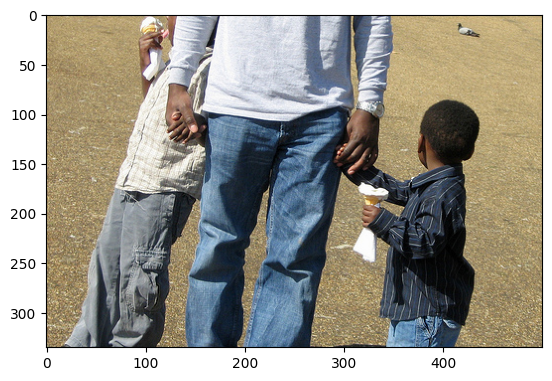

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Caption:  a boy in a red shirt is standing on a stone wall holding a fishing pole
BLEU score: 0.3549752724226501
Caption:  a boy in a red shirt is standing on a stone wall holding a fishing pole
BLEU score: 0.3549752724226501


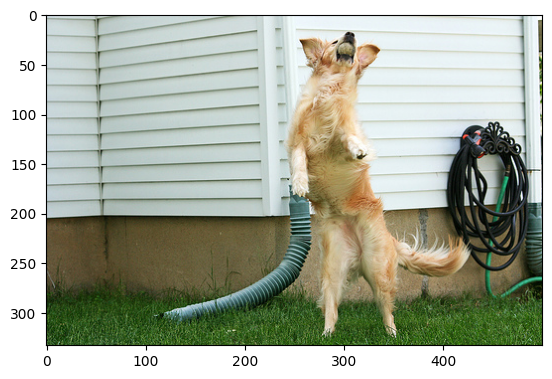

Caption:  a dog jumps over a barrier
BLEU score: 0.5265753584723774
Caption:  a dog jumps over a barrier
BLEU score: 0.5265753584723774


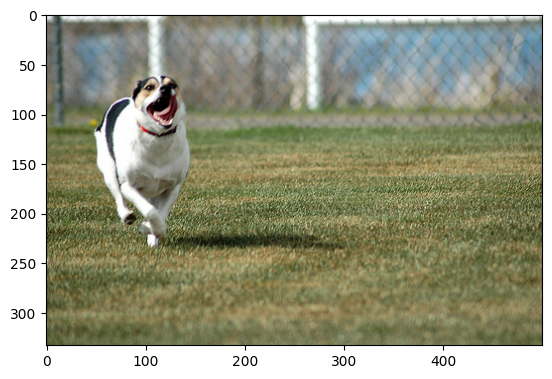

Caption:  a dog is running through a field
BLEU score: 0.6617131856095154
Caption:  a dog is running through a field
BLEU score: 0.6617131856095154


In [ ]:
"""
This code is a function called "show_result" that takes in an index of an
image and an optional parameter for the file path of where the images are located.
The function uses the index to find the corresponding image file name from a list
of keys of a dictionary containing image features. It then takes that image and
reshapes it to the correct dimensions and uses it as an input to generate a
caption using another provided function called "generate_caption". This generated
caption is then used as an input along with the image file name to another provided
function called "compute_bleu" which calculates the BLEU score for the generated caption.
Finally, the image is displayed using plt.imshow() and the generated caption and BLEU
score are printed out.
"""

def show_result(img_index, image_path = test_dir_path):
  pic = list(t_features.keys())[img_index]
  # print(pic[:-4])
  # return
  image = t_features[pic].reshape((1,2048))
  x = plt.imread(test_dir_path+ '/' + pic)
  plt.imshow(x)
  plt.show()
  caption = generate_caption(tokenizer, image, max_length, final_model)
  bleu_score = compute_bleu(pic, caption)

  print("Caption:", caption)
  print("BLEU score:", bleu_score)

  print("Caption:", caption)
  print("BLEU score:", bleu_score)

show_result(1)
show_result(10)
show_result(random.randint(0,1000))




# Reinforcement Learning

## Creating Environment

In [ ]:
"""
This is a class called ICEnv, which is used to create a custom environment for an image captioning task.
The class inherits from the Env class of OpenAI Gym, which is a library that provides a standardized
interface for creating and interacting with environments for reinforcement learning.


The __init__ method is used to initialize the environment by setting the initial state, action space,
and observation space. It takes several arguments, such as the initial image, an ID for the image,
the maximum length of the caption, the number of words in the vocabulary, the start and end sequences
for the caption, and a tokenizer to convert between word sequences and text.

The step method is used to take an action in the environment and return the new state, reward, and
whether the environment is done. The action is an integer representing the next word in the caption,
and the method updates the state by inserting the word into the caption and calculating the reward
based on the quality of the caption using BLEU score.

The reset method is used to reset the environment to its initial state, which includes the initial image
and caption. It takes optional arguments to change the image and ID.

The render method is used to display the current state of the environment, which includes the
current caption and optionally the image.

This code is basically creating a custom environment for image captioning task, where agent can
generate captions by taking actions, the environment will provide a reward based on the quality
of the caption generated using BLEU score which agent will try to maximize.
"""
class ICEnv(Env):
  def __init__(self, image, img_id, max_len, num_words, startseq, endseq,
               tokenizer):
    self.prev_rewards = []
    self.reward = 0
    self.total_rewards = 0
    self.max_len = max_len
    self.num_words = num_words
    self.startseq = startseq
    self.endseq = endseq
    self.done = False
    self.img_id = img_id
    self.tokenizer = tokenizer
    self.seq_len = 1

    self.observation_space = {'image': spaces.Box(low = 0, high = 255,
                                                  shape=(2048,)),
                              "words": spaces.Box(low = 0, high = 2075,
                                                  shape=(self.max_len,))}

    self.action_space = spaces.Discrete(self.num_words, start = 1)

    self.state = {'image': image,
                  "words": np.pad([self.startseq], (0, self.max_len -1),
                                  'constant' , constant_values=(0,0))}




  def step(self, action):
    info = {}

    """ Might need to change """
    # Update previous reward
    self.prev_rewards.append(self.reward)

    # Apply action
    for i, word in enumerate(self.state['words']):
      if word == 0:
        self.state['words'][i] = action
        self.seq_len += 1
        break

    # Calculate reward
    ind_caption = []
    for word in self.state['words']:
        if word == self.endseq or word == 0:
          break
        elif word == self.startseq:
          continue
        else:
          ind_caption.append(word)

    caption = tokenizer.sequences_to_texts([ind_caption])[0]
    # img_idd = self.img_id+'.jpg'
    references = train_caps[self.img_id+'.jpg']
    self.reward = compute_bleu(img_id_to_url(self.img_id), caption, False)
    # sentence_bleu(references, caption)
    self.total_rewards += self.reward


    # Check if it's done
    if action == self.endseq or self.seq_len == self.max_len:
      self.done = True


    return self.state, self.reward, self.done, info


  def reset(self, image = None, img_id = None):
    self.prev_rewards = []
    self.reward = 0
    self.total_rewards = 0
    self.done = False
    self.seq_len = 1

    self.state["words"]= np.pad([self.startseq], (0, self.max_len -1),
                                  'constant' , constant_values=(0,0))


    if image != None and img_id != None:
      self.state['image'] = image
      self.img_id = img_id

    return self.state

  def render(self, with_image = False):
    if with_image:
      img_path = pictures_dir_path + '/' + img_id_to_url(self.img_id)
      plt.imshow(plt.imread(img_path))
      plt.show()

    ind_caption = []
    for word in self.state['words']:
      if word == 0:
        break
      else:
        ind_caption.append(word)
    caption = tokenizer.sequences_to_texts([ind_caption])[0]
    print(caption)

In [ ]:
"""
This object is then used to interact with an environment where a language model generates captions
for images. The ICEnv class's step() method allows the language model to select a word at a time,
and the reset() method allows to switch the image the caption is
generated for.
"""
tmp_img_id = list(train_caps.keys())[0]
tmp_img_id, file_extension = os.path.splitext(tmp_img_id)
tmp_img = features[img_id_to_url(tmp_img_id)]

env = ICEnv(image= tmp_img, img_id= tmp_img_id,
            max_len=max_length, num_words=num_words,
            startseq = tokenizer.word_index['startseq'],
            endseq = tokenizer.word_index['endseq'], tokenizer= tokenizer)

In [ ]:
env.action_space.sample()

1471

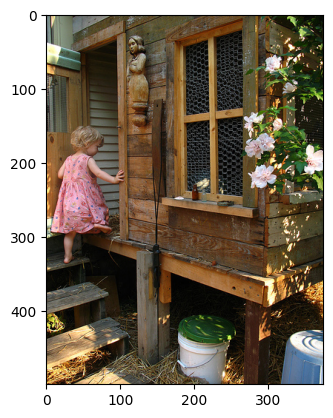

startseq
startseq
state is: [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] state len is: 16
startseq professional
state is: [  3 971   0   0   0   0   0   0   0   0   0   0   0   0   0   0] state len is: 16
startseq professional sheep
state is: [  3 971 660   0   0   0   0   0   0   0   0   0   0   0   0   0] state len is: 16
startseq professional sheep cheerleader
state is: [   3  971  660 1459    0    0    0    0    0    0    0    0    0    0
    0    0] state len is: 16
startseq professional sheep cheerleader rests
state is: [   3  971  660 1459 1139    0    0    0    0    0    0    0    0    0
    0    0] state len is: 16
startseq professional sheep cheerleader rests distant
state is: [   3  971  660 1459 1139 1711    0    0    0    0    0    0    0    0
    0    0] state len is: 16
startseq professional sheep cheerleader rests distant jumped
state is: [   3  971  660 1459 1139 1711  905    0    0    0    0    0    0    0
    0    0] state len is: 16
startseq professional sheep cheerleader rest

In [ ]:
"""
This code is running a loop for a specified number of episodes (episodes) and in each episode, it:

Resets the environment by calling the reset() function on the env object, which sets the initial
state of the environment.
Sets a flag done to False
Initializes a score variable to 0
Renders the environment with an image by calling render(with_image=True) on the env object
It enters into a while loop which runs until the done flag is True.
In each iteration of the while loop:
it renders the environment by calling render() on the env object.
it prints the current state of the environment, which is the list of words in the current sentence
and the length of the list
it samples an action from the action space of the environment and assigns the value to the variable action
it takes the action by calling the step(action) function on the env object, which returns the new state,
reward, done flag and additional information
it adds the reward to the score
After the while loop, it prints the episode number and the final score.
"""
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    env.render(with_image = True)
    while not done:
        env.render()
        print('state is:',env.state['words'], 'state len is:', len(env.state['words']))
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

# Final Training

Generator model is already pretrained using MLE

## Generating fake samples

In [ ]:
"""
For the first time
"""
### Generating fake samples
print('here')
fake_captions = {}
# for img_url in tqdm.tqdm(features.keys()):
#   image = features[img_url].reshape((1,2048))

#   fake_cap = generate_caption(tokenizer, image,
#                               max_length, final_model)

#   fake_captions[img_url] = fake_cap
# # ### Save the features in the images1 pickle file

# with open(os.path.join(project_path,"fake_captions_f.pkl"), "wb") as fake_caps_pickle:
#     pickle.dump(fake_captions, fake_caps_pickle)

"""
Fo the other times
"""
  # Loading saved captions
fake_captions = pickle.load(open(os.path.join(project_path,"fake_captions_f.pkl"), "rb"))

here


## Pre-training Discriminator

### Creating Discriminator

In [ ]:
"""
This code defines a function called "create_discriminator()" that creates a neural network model.
The function takes no input, but it creates two inputs inside the function, one is named "img_features"
which is an input layer and the
shape of this input is 1, 2048. The other input is named "caption" and it has shape (max_length,).

The function then applies an Embedding layer on the caption input and the output is embedded_caption,
this layer is used to reduce the dimensionality of the input and learn a dense representation of the input.

Then, it concatenates the img_features and embedded_caption along the axis 1, and the output of this
concatenation is fed into an LSTM layer with 512 units.

Then, the output of the LSTM layer is passed through a dense layer with 512 units and an activation
function of "leaky_relu". The output of this dense layer is passed through a dropout layer with a rate
of 0.4 to reduce overfitting, and the final output of the model is passed through a dense layer with 1
unit and sigmoid activation function.

The inputs of the model are img_features and caption, and the output is the final output of the model,
and the model is returned by the function.
"""
def create_discriminator():
  img_features = Input(shape=(1,2048,))

  caption = Input(shape=(max_length,))
  embedded_caption = Embedding(num_words, embedding_dim, mask_zero=True)(caption)


  # disc_input = add([img_features, embedded_caption])
  disc_input = tf.concat([img_features, embedded_caption], axis=1)

  disc_lstm = LSTM(512)(disc_input)
  disc_dense = Dense(512, activation='leaky_relu')(disc_lstm)
  disc_dropout = Dropout(0.4)
  outputs = Dense(1, activation='sigmoid')(disc_dense)

  disc_model = Model(inputs=[img_features, caption], outputs=outputs)
  # model.summary()

  return disc_model

In [ ]:
disc = create_discriminator()
# print(disc.layers[2].weights, disc.layers[2].trainable)
disc.layers[2].set_weights(final_model.layers[2].weights)
disc.layers[2].trainable = False
disc.summary()
# print(disc.layers[2].weights, disc.layers[2].trainable)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1, 2048)]            0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 16, 2048)             4249600   ['input_5[0][0]']             
                                                                                                  
 tf.concat (TFOpLambda)      (None, 17, 2048)             0         ['input_4[0][0]',             
                                                                     'embedding_1[0][0]']   

In [ ]:
def load_discriminator():
  disc = tf.keras.models.load_model(os.path.join(project_path,'Disc_V1_f.h5'))
  return disc

In [ ]:
"""
This code is defining a function called "generate_real_fake_wrong_samples()".
The purpose of this function is to generate samples of 3 different types: real, fake and wrong.

It starts by generating "fake" samples. It initializes an empty array called "fake_y" with 4000 zero values.
It also initializes empty lists called "fake_features" and "fake_caps".
It then iterates through the "fake_captions" dictionary, each iteration, it takes the image feature and
caption and appends it to the "fake_features" and "fake_caps" lists respectively.

Then it generates "real" samples. It initializes an empty array called "real_y" with 8000 one values.
It also initializes empty lists called "real_features" and "real_caps".
It then iterates through the "train_caps" dictionary, each iteration, it takes the image feature and 2
random captions of the same image and appends it to the "real_features" and "real_caps" lists respectively.

Then it generates "wrong" samples. It initializes an empty array called "wrong_y" with 4000 zero values.
It also initializes empty lists called "wrong_features" and "wrong_caps".
It then iterates through the "train_caps" dictionary, each iteration, it takes the image feature and a
random caption of another image and appends it to the "wrong_features" and "wrong_caps" lists respectively.

Finally, it concatenates the real, fake and wrong features, captions and labels (real_y, fake_y, wrong_y)
into 3 arrays called "disc_features", "disc_caps" and "disc_y" and returns them.
"""
def generate_real_fake_wrong_samples():
    # fake captions
    fake_y = np.zeros((4000,))
    fake_features = []
    fake_caps = []
    for url, caption in fake_captions.items():
      feature = features[url]
      fake_features.append(feature)
      fake_caps.append(caption)

    # real captions
    real_y = np.ones((8000,))
    real_features = []
    real_caps = []
    for img_id in train_caps:
      filename, file_extension = os.path.splitext(img_id)

      img_url = img_id_to_url(filename)
      feature = features[img_url]
      real_features.append(feature)
      real_features.append(feature)
      real_cap1, real_cap2 = random.sample(train_caps[img_id], 2)
      real_caps.append(real_cap1)
      real_caps.append(real_cap2)


    wrong_y = np.zeros((4000,))
    wrong_features = []
    wrong_caps = []
    for img_id in train_caps:
      filename1, file_extension = os.path.splitext(img_id)

      img_url = img_id_to_url(filename1)
      feature = features[img_url]
      wrong_features.append(feature)

      # Finding another image
      second_feature_sorted = False
      while not second_feature_sorted:
        second_id = random.choice(list(train_caps.keys()))
        if img_id != second_id:
          second_feature_sorted = True

      wrong_caps.append(random.choice(train_caps[second_id]))

    disc_features = real_features + fake_features + wrong_features
    disc_caps = real_caps + fake_caps + wrong_caps
    disc_y = np.concatenate((real_y, fake_y, wrong_y), axis = 0)
    return disc_features, disc_caps, disc_y

In [ ]:
disc_features, disc_caps, disc_y = generate_real_fake_wrong_samples()
np_disc_features = np.array(disc_features)
np_disc_features = np_disc_features[:16000, :]
np_disc_caps = np.array(disc_caps)

In [ ]:
disc_sequences = tokenizer.texts_to_sequences(np_disc_caps)
disc_padded = pad_sequences(disc_sequences, maxlen=max_length)
disc_padded = disc_padded[:16000, :]
# np_disc_y = disc_y.reshape(12000,1)
# disc_padded.shape
# np_disc_features.shape
# np_disc_caps.shape
# disc.summary()
print(np_disc_features.shape, disc_padded.shape, disc_y.shape)

(16000, 2048) (16000, 16) (16000,)


In [ ]:
disc.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])
# np_disc_features.reshape([12000,1,2048]).shape
disc.fit(x=[np_disc_features.reshape([16000,1,2048]), disc_padded], y=disc_y.reshape(16000,1), verbose=1, epochs=15, batch_size=16)

Epoch 1/15
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6930 - accuracy: 0.5257
Epoch 2/15
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6743 - accuracy: 0.5817
Epoch 3/15
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6492 - accuracy: 0.6125
Epoch 4/15
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6082 - accuracy: 0.6552
Epoch 5/15
1000/1000 [==============================] - 45s 45ms/step - loss: 0.5214 - accuracy: 0.7251
Epoch 6/15
1000/1000 [==============================] - 45s 45ms/step - loss: 0.3830 - accuracy: 0.8117
Epoch 7/15
1000/1000 [==============================] - 45s 45ms/step - loss: 0.2411 - accuracy: 0.8915
Epoch 8/15
1000/1000 [==============================] - 45s 45ms/step - loss: 0.1640 - accuracy: 0.9308
Epoch 9/15
1000/1000 [==============================] - 46s 46ms/step - loss: 0.1149 - accuracy: 0.9526
Epoch 10/15
1000/1000 [==============================] - 46s 46m

In [ ]:
model_Disc_name = 'Disc_V1_f' + '.h5'
model_Disc_path = os.path.join(project_path, model_Disc_name)
# only first time
disc.save(model_Disc_path )


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
disc = load_discriminator()

## Training GAN

In [ ]:
gen = final_model

In [ ]:
"""
This code defines a function named "post_zero_to_pre" that takes in an array as an input.
The function first creates an empty list called "non_zero". It then iterates through each
element in the input array, checks if the element is not equal to 0, and if it is not, it
appends it to the "non_zero" list.

After that, it creates an array of zeroes with the length of the difference between the
length of the input array and the length of the "non_zero" list. Finally, it concatenates
(combines) the array of zeroes with the "non_zero" list, and returns the resulting concatenated array.
The function's purpose is to move all non zero elements of the array to the front of the array, and
pad the remaining with zeroes.
"""
def post_zero_to_pre(array):
  non_zero = []
  the_len = len(array)
  for num in array:
    if num != 0:
      non_zero.append(num)
  # np_non_zero = np.array(non_zero)
  pre_z = np.zeros(the_len - len(non_zero), dtype=np.int32)
  return np.concatenate((pre_z, np.array(non_zero)), axis =0)

# post_zero_to_pre([1,2,3, 0,0,0,0])

### Sampling and Creating Batches Of Data

In [ ]:
t = [2, 12, 111, 5, 2, 74, 4]
tt = []
for i in range(1, len(t)+1):
    curr_s = np.concatenate(([3]+t[:i], np.zeros((max_length - len(t[:i])-1))), axis=0)
    tt.append(curr_s)
print(tt)

[array([3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 3.,  2., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.]), array([  3.,   2.,  12., 111.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.]), array([  3.,   2.,  12., 111.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.]), array([  3.,   2.,  12., 111.,   5.,   2.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.]), array([  3.,   2.,  12., 111.,   5.,   2.,  74.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.]), array([  3.,   2.,  12., 111.,   5.,   2.,  74.,   4.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])]


In [ ]:
"""
The code is generating a caption for an image using reinforcement learning. It does so by creating an
environment for the caption generation process, sampling words to add to the caption, and then adjusting
the rewards based on the quality of the generated caption.

It starts by initializing some variables and creating an environment object, called ICEnv, which takes
the image, the maximum length of the caption, the number of words, and tokenizer as its inputs.

Then, a while loop is used to generate the caption word by word. In each iteration, the current state
of the caption is passed to a pre-trained model, which predicts the probability of each word in the
vocabulary being the next word in the caption. Then, a word is sampled from this probability distribution and added to the caption. The environment is then updated with the new word and the process continues until the maximum length of the caption is reached or the 'endseq' token is generated.

The function also returns the final reward, the state of the environment after each word, the actions
taken, and the final generated caption.
"""
def sample_caption_rl(tokenizer, image, img_id, max_length, gmodel, num_words,\
                      with_render=True,with_img=True):
  # Creating env
  print(img_id)
  env = ICEnv(image= image, img_id= img_id,
            max_len=max_length, num_words=num_words,
            startseq = tokenizer.word_index['startseq'],
            endseq = tokenizer.word_index['endseq'], tokenizer= tokenizer)
  # Sampling
  state = env.reset()
  done = False
  score = 0
  if with_render:
    env.render(with_image = with_img)
  actions = []
  caption = 'startseq'
  total_states = []
  while not done:
      # env.render()
      pre_zero_seq = post_zero_to_pre(env.state['words'])

      word_probs = gmodel.predict([np.array(env.state['image']).reshape((1,2048)),
                                  np.array([pre_zero_seq])],verbose=0)

      dist = tfp.distributions.Categorical(probs=word_probs, dtype=tf.float32)
      tf_predicted_index = dist.sample()
      predicted_index = np.array(tf_predicted_index)

      new_word = tokenizer.sequences_to_texts([predicted_index])[0]
      caption += ' ' + new_word

      action = tokenizer.word_index[new_word]
      actions.append(action)

      # print(env.state['words'])

      n_state, reward, done, info = env.step(action)


  for i in range(1, len(actions)+1):
    curr_state = np.concatenate(([3]+actions[:i-1], np.zeros((max_length - len(actions[:i-1])-1), dtype=np.int32)), axis=0)
    total_states.append({'image':env.state['image'],
                         'words':curr_state})

  return reward, total_states, actions, caption

# sample_caption_rl(tokenizer, features['667626_18933d713e.jpg'], 338532,max_length, gen, num_words)


In [ ]:
"""
This code creates a batch of fake captions for an image dataset. The batch size is specified by the user
and the captions are generated by the sample_caption_rl function. The function starts by initializing an
empty dictionary called fake_batch and three empty lists called total_actions, total_rewards, and total_urls.


The code enters a while loop, where it continues to iterate until the length of the fake_batch dictionary
reaches the desired batch size. Inside the while loop, the function chooses a random image id from the
train_caps dictionary using the random.choice method. Then it gets the image url using the img_id_to_url
function. Next, it gets the feature of the image and reshapes it to a 1x2048 numpy array.

The sample_caption_rl function is called with the tokenizer, feature, image id, max_length, gen, num_words,
with_render and with_img parameters. This function generates a caption for the image and returns the reward,
states, actions and the caption. The actions, rewards, and states are appended to the total_actions,
total_rewards and total_states list respectively. The image url is added to the total_urls list. Finally,
the caption is added to the fake_batch dictionary with the image url as the key.

Once the while loop completes, the function returns the fake_batch, total_actions, total_rewards,
total_urls, and total_states. These can be used for further processing or training.
"""
def create_fake_captions_batch(batch_size):
  fake_batch = {}
  total_actions = []
  total_rewards = []
  total_urls = []
  total_states = []
  while len(fake_batch) < batch_size:
    img_id = random.choice(list(train_caps.keys()))
    img_id, file_extension = os.path.splitext(img_id)

    img_url = img_id_to_url(img_id)
    feature = features[img_url].reshape((1,2048))

    rewards, states, actions, caption = sample_caption_rl(tokenizer, feature,\
                                                          img_id, max_length,\
                                gen, num_words, with_render=False,\
                                 with_img=False)
    total_actions.append(actions)
    total_rewards.append(rewards)
    fake_batch[img_url] = caption
    total_urls.append(img_url)
    total_states.append(states)
  return fake_batch, total_actions, total_rewards, total_urls, total_states

# create_fake_captions_batch(4)


### Calculating Scores

In [ ]:
"""
This code defines a function called calculate_p that takes in five arguments:

img_cap_pairs: a dictionary where the keys are image URLs and the values are captions
disc: a discriminator model
tokenizer: an object used to convert captions to numerical sequences
max_length: the maximum length of captions
batch_size: the number of images in the batch
The function first takes the image URLs from the img_cap_pairs dictionary and uses them to retrieve the
corresponding image features. These image features are then stored in a list called img_features.

Next, the captions from the img_cap_pairs dictionary are stored in a list called captions. The tokenizer is
used to convert the captions to numerical sequences, which are then padded to the max_length using the
pad_sequences function. These padded sequences are then stored in a numpy array called np_padded.

The disc model is then used to predict the probability that each image-caption pair is real.
The image features, np_features, and the padded caption sequences, np_padded, are passed to the
model as input. The predictions are stored in a numpy array called probs which is then flattened and returned.

"""
def calculate_p(img_cap_pairs, disc, tokenizer, max_length, batch_size):
  img_urls = list(img_cap_pairs.keys())
  img_features = []
  for url in img_urls:
    if url in t_features:
      feature = t_features[url]
    else:
      feature = features[url]
    img_features.append(feature)

  captions = list(img_cap_pairs.values())

  # print(np.array(img_features).shape, np.array(captions).shape)
  # x=[np_disc_features.reshape([16000,1,2048]), disc_padded], y=disc_y.reshape(16000,1)
  np_features = np.array(img_features).reshape(batch_size, 1, 2048)

  sequences = tokenizer.texts_to_sequences(captions)
  padded = pad_sequences(sequences, maxlen=max_length)
  np_padded = np.array(padded)

  probs = disc.predict([np_features, np_padded])

  return probs.flatten()
# calculate_p

In [ ]:
"""
This code is defining a function called "calculate_s" that takes in a dictionary of image-caption pairs
(img_cap_pairs) as its input.

The function creates an empty list called "s_values", and then loops through each image URL (url) in the
input dictionary. For each image URL, it uses a function called "compute_bleu" to calculate a score
(bleu_score) for the associated caption (img_cap_pairs[url]). It then appends this score to the
"s_values" list.

Finally, the function returns the "s_values" list, which contains the scores for each caption in the input
dictionary.
"""
def calculate_s(img_cap_pairs):
  s_values = []
  for url in img_cap_pairs:
    bleu_score = compute_bleu(url, img_cap_pairs[url], False)
    s_values.append(bleu_score)
  return s_values

# calculate_s(fake_batch)

In [ ]:
"""
This code is defining a function called "calculate_r" that takes in three inputs:
"p_values", "s_values", and "lambda_val". The function uses numpy to create numpy
arrays from the input lists "p_values" and "s_values". The function then multiplies
the array of "p_values" by "lambda_val" and the array of "s_values" by "(1-lambda_val)".
It then adds the two resulting arrays together, element-wise and return the sum.
The result is the rewards for each image caption pair.
"""
def calculate_r(p_values, s_values, lambda_val):
  np_p = np.array(p_values)
  np_s = np.array(s_values)

  return lambda_val*np_p + (1-lambda_val)*np_s

calculate_r([1,2,3,4], [0,0,0,0], 0.5)

array([0.5, 1. , 1.5, 2. ])

### Updatin Generator Weights

In [ ]:
"""
This code is calculating a reward for a generated caption, using a combination of two different metrics:
BLEU score and a discriminator score.

First, it takes an image url and generates a caption using a pre-trained generator model (gmodel) and a
tokenizer. The generated caption is then passed to the function compute_bleu() to calculate the BLEU score,
which measures the similarity of the generated caption to a set of reference captions.

Next, the generated caption and image url are passed to the function calculate_p() which uses a discriminator
model (dmodel) and tokenizer to predict the probability of the generated caption being real.

Finally, the code calculates the final reward as a linear combination of the BLEU score and the discriminator
score, where the weight of each component is controlled by the parameter lambda_val. The final reward is
returned.

"""
def calculate_greedy_decoding_reward(img_url, tokenizer, gmodel, max_len,\
                                     for_training=True, dmodel=None,\
                                     lambda_val=0):
  if for_training:
    feature = features[img_url]
  else:
    feature = t_features[img_url]
  picture = np.array(feature).reshape((1,2048))
  caption = generate_caption(tokenizer, picture, max_len, gmodel)
  # print(caption)

  bleu_score = compute_bleu(img_url, caption, not for_training)
  disc_score = calculate_p({img_url: caption}, dmodel,\
                           tokenizer,max_len, 1)

  # print('bleu: ',bleu_score, 'p: ', disc_score,\
  #       'reward: ',bleu_score*(1-lambda_val) + disc_score*(lambda_val),\
  #       'lambda: ', lambda_val)
  return bleu_score*(1-lambda_val) + disc_score*(lambda_val)

# calculate_greedy_decoding_reward('667626_18933d713e.jpg', tokenizer, gen, max_length)

In [ ]:
"""
This code defines a function called "calculate_loss", which calculates the loss for a given action, reward,
and set of probabilities.
The function takes a few input arguments.
greedy_reward: a float representing the reward of the caption generated by a greedy decoding algorithm
The function first create a categorical distribution with probs. Then it calculates the log probability of the
action.
It then calculates the loss as the negative of the product of log_prob and the difference between the reward
and greedy_reward.
It then checks if the loss is NaN, and if it is, it prints the minimum and maximum values of the probs array.
It returns the loss value calculated.
"""
def calculate_loss(gmodel, action, reward, probs, img_url, tokenizer, max_len, greedy_reward):
    dist = tfp.distributions.Categorical(probs=probs, dtype=tf.float32)
    log_prob = dist.log_prob(action)
    loss = -log_prob*(reward - greedy_reward)
    # print('reward, greedy reward:', reward, greedy_reward)
    # print('max prob and action are:', np.argmax(probs), action)
    if math.isnan(loss):
      print('loss reached nan')
      print(np.min(probs), np.max(probs))

    return loss

In [ ]:
"""
This code is defining a function called update_generator that takes in several parameters such as a list of
rewards (r_values), a batch of data (batch), a list of actions (actions), the current states of the generator
model (states), the generator model (gmodel), a list of image URLs (urls), the maximum length of captions
(max_len), the discriminator model (dmodel), and a lambda value (lambda_val).

The function then defines an Adam optimizer and initializes a counter variable. It then loops through the
zip of the states, rewards, actions, and image URLs, and for each iteration, it calculates the "greedy
reward" which is the reward of the caption generated by the generator model, by calling the function
calculate_greedy_decoding_reward. Then it loops through the current actions and states and inside the
loop, it uses TensorFlow's GradientTape to record the forward pass of the generator model. It converts
the state's 'words' to a pre-zero format and passes the state's 'image' and pre_zero_seq to the generator
model, and get the word probabilities from the model. It then checks if the minimum value of word_probs is
zero or NaN, if so it will break the loop. If not, it calculates the loss using the function calculate_loss
with the action, reward, word_probs, img_url, tokenizer, max_len, and greedy_reward as arguments. It then
calculates the gradients using GradientTape and applies the gradients to the generator model using the
optimizer. Finally, it returns the updated generator model.
"""
def update_generator(r_values, batch, actions, states, gmodel, urls, max_len,\
                     dmodel, lambda_val):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, clipvalue=.5)
  counter = 0

  for current_states, reward, current_actions, img_url in zip(states, r_values, actions, urls):
    counter += 1
    # if counter %2 == 0:
      # print(f'{100*(counter/len(urls))}%')

    greedy_reward = calculate_greedy_decoding_reward(img_url, tokenizer,\
                                                       gmodel, max_len, True,\
                                                       dmodel, lambda_val)

    for action, state in zip(current_actions, current_states):


      with tf.GradientTape() as tape:

        pre_zero_seq = post_zero_to_pre(state['words'])
        word_probs = gmodel([np.array(state['image']).reshape((1,2048)),
                                  np.array([pre_zero_seq])], training = True)

        if np.min(word_probs) == 0:
          # word_probs += 1.1499141e-24
          # print('here')
          break
        if math.isnan(np.min(word_probs)):
          print('model reached nan')
          return

        loss = calculate_loss(gmodel, action, reward, word_probs, img_url, tokenizer, max_len, greedy_reward)


      grads = tape.gradient(loss, gmodel.trainable_variables)

      optimizer.apply_gradients(zip(grads, gmodel.trainable_variables))
  return gmodel


In [ ]:
model_final_name = 'final_model_f_V5.h5'
model_final_path = os.path.join(project_path, model_final_name)
gen = tf.keras.models.load_model(model_final_path)
tpic = np.array(features['667626_18933d713e.jpg']).reshape((1,2048))
# generate_caption(tokenizer, tpic, max_length, gen)

### Updating Discriminator

In [ ]:
"""
This code is generating fake captions by selecting a random set of images from a dataset and passing them
through a language model (gmodel). The function takes as input the language model, a tokenizer, a maximum
length for the captions, and the number of samples (n_samples) to generate. It first selects n_samples
randomly from the dataset, then for each selected image, it passes the image through the language model with
the generate_caption() function to generate a caption. The generated captions are then stored in a dictionary
(gen_captions) with the image URL as the key and the generated caption as the value. The function returns
this dictionary of generated captions.
"""
def generate_fake_captions(gmodel, tokenizer, max_len, n_samples):
  gen_captions = {}
  all_feature_keys = list(features.keys())
  random_img_urls = random.sample(all_feature_keys, n_samples)
  for img_url in random_img_urls:
    image = features[img_url].reshape((1,2048))

    gen_cap = generate_caption(tokenizer, image, max_len, gmodel)

    gen_captions[img_url] = gen_cap

  return gen_captions


In [ ]:
"""
This code is generating a set of fake, real and wrong captions with their corresponding image features.
It starts by initializing some variables, such as the number of samples for each type of caption (real, fake
and wrong),
and an array of all image ids in the training set.

It then generates fake captions using the generate_fake_captions function and collects the corresponding
image feature and caption for each generated fake caption.
It then selects a random set of real captions from the training set, along with their corresponding image
features,
It also selects a random set of wrong captions, which are captions that are not associated with the
corresponding image feature,
and also collects their corresponding image feature.
Finally, it concatenates all the real, fake, and wrong image features, captions and labels,
pad the captions and return the concatenated image features, padded captions and labels as a tuple.
"""
def generate_real_fake_wrong_samples2(n_samples, gmodel):
    all_img_ids = list(train_caps.keys())
    f_samples = int(n_samples/4)
    r_samples = int(n_samples/4)
    w_samples = int(n_samples/4)

    # fake captions
    fake_y = np.zeros((f_samples,))
    fake_features = []
    fake_caps = []
    generated_captions = generate_fake_captions(gmodel, tokenizer, max_length, f_samples)
    for url, caption in generated_captions.items():
      feature = features[url]
      fake_features.append(feature)
      fake_caps.append(caption)

    # real captions
    real_y = np.ones((2*r_samples,))
    real_features = []
    real_caps = []
    random_r_ids = random.sample(all_img_ids, r_samples)
    for img_id in random_r_ids:
      filename, file_extension = os.path.splitext(img_id)

      img_url = img_id_to_url(filename)
      feature = features[img_url]
      real_features.append(feature)
      real_features.append(feature)
      real_cap1, real_cap2 = random.sample(train_caps[img_id], 2)
      real_caps.append(real_cap1)
      real_caps.append(real_cap2)



    # wrong captions
    wrong_y = np.zeros((w_samples,))
    wrong_features = []
    wrong_caps = []
    random_w_ids = random.sample(all_img_ids, w_samples)
    for img_id in random_w_ids:
      filename, file_extension = os.path.splitext(img_id)

      img_url = img_id_to_url(filename)
      feature = features[img_url]
      wrong_features.append(feature)

      # Finding another image
      second_feature_sorted = False
      while not second_feature_sorted:
        second_id = random.choice(list(train_caps.keys()))
        if img_id != second_id:
          second_feature_sorted = True

      wrong_caps.append(random.choice(train_caps[second_id]))

    disc_features = real_features + fake_features + wrong_features
    disc_caps = real_caps + fake_caps + wrong_caps
    disc_y = np.concatenate((real_y, fake_y, wrong_y), axis = 0)

    # added
    np_disc_features = np.array(disc_features)
    np_disc_caps = np.array(disc_caps)

    disc_sequences = tokenizer.texts_to_sequences(np_disc_caps)
    disc_padded = pad_sequences(disc_sequences, maxlen=max_length)
    print(np_disc_features.shape, disc_padded.shape, disc_y.shape)

    return np_disc_features, disc_padded, disc_y


## Main Loop

In [ ]:
lambda_val = 0.2

In [ ]:
converged = False
mini_batch = 8
disc_data_batch = 128
disc_training_batch = 8
disc_epochs = 4
n_epochs = 8


"""
This code is training a generative model called "gen" and a discriminative model called "disc" using a
technique called reinforcement learning. The code runs for a certain number of epochs (n_epochs) and in
each epoch it performs the following steps:

Generate a batch of fake captions (fake_batch) using the generator model and some additional inputs
(actions, rewards, urls, states) by calling the function create_fake_captions_batch(mini_batch)
Calculate the probability (p_values) of the fake captions being real using the discriminator model.
Calculate the relevance (s_values) of the fake captions using some additional inputs (urls)
Calculate the rewards (r_values) of the fake captions by combining the probability and relevance values with
a parameter lambda_val
Update the generator model using the rewards, fake captions, actions, states, urls and discriminator model
by calling the function update_generator(r_values, fake_batch, actions, states, gen, urls, max_length, disc,
lambda_val)
Generate a batch of real, fake and wrong captions (disc_features_batch, disc_padded_batch, disc_y_batch)
using the generator model and the function generate_real_fake_wrong_samples2(disc_data_batch, gen)
Update the discriminator model using the generated captions and their labels (real, fake, wrong) by
calling the function disc
"""

#Only first time

# for i in range(n_epochs):
#   print(f'Epoch {i+1}/{n_epochs}')
#   # g part
#   print('generating samples for generator ...')
#   fake_batch, actions, rewards, urls, states = create_fake_captions_batch(mini_batch)

#   p_values = calculate_p(fake_batch, disc, tokenizer, max_length, mini_batch)
#   s_values = calculate_s(fake_batch)
#   r_values = calculate_r(p_values, s_values, lambda_val)
#   print('updating generator ...')
#   gen = update_generator(r_values, fake_batch, actions, states, gen, urls,\
#                          max_length, disc, lambda_val)
#   # d part
#   # break
#   print('generating samples for discriminator ...')
#   disc_features_batch, disc_padded_batch, disc_y_batch = generate_real_fake_wrong_samples2(disc_data_batch, gen)
#   print('updating discriminator ...')
#   disc.fit(x=[disc_features_batch.reshape([disc_data_batch,1,2048]),
#                       disc_padded_batch],y=disc_y_batch.reshape(disc_data_batch,1),
#                    verbose=1, epochs=disc_epochs,
#                    batch_size=disc_training_batch)
#   if i==n_epochs-1:
#     final_model_Disc_name = 'Final_Disc_Model_f' + '.h5'
#     final_model_Disc_path = os.path.join(project_path, final_model_Disc_name)
#     disc.save(final_model_Disc_path )



'\nThis code is training a generative model called "gen" and a discriminative model called "disc" using a\ntechnique called reinforcement learning. The code runs for a certain number of epochs (n_epochs) and in\neach epoch it performs the following steps:\n\nGenerate a batch of fake captions (fake_batch) using the generator model and some additional inputs\n(actions, rewards, urls, states) by calling the function create_fake_captions_batch(mini_batch)\nCalculate the probability (p_values) of the fake captions being real using the discriminator model.\nCalculate the relevance (s_values) of the fake captions using some additional inputs (urls)\nCalculate the rewards (r_values) of the fake captions by combining the probability and relevance values with\na parameter lambda_val\nUpdate the generator model using the rewards, fake captions, actions, states, urls and discriminator model\nby calling the function update_generator(r_values, fake_batch, actions, states, gen, urls, max_length, disc

In [ ]:
final_model_Disc_name = 'Final_Disc_Model_f' + '.h5'
final_model_Disc_path = os.path.join(project_path, final_model_Disc_name)
disc = tf.keras.models.load_model(final_model_Disc_path)

In [ ]:
import tqdm
import matplotlib.pyplot as plt

lambda_val = 0.2
def t(number, second=20):
    total_range = range(1, number + 1)
    weights_combinations = [
        (1, 0, 0, 0),
        (0.5, 0.5, 0, 0),
        (0.33, 0.33, 0.33, 0),
        (0.25, 0.25, 0.25, 0.25)
    ]

    avg_bleu_scores = []

    for weights in weights_combinations:
        bleu_scores = []  # List to store BLEU scores for the current weights

        for img_index in tqdm.tqdm(total_range):
            pic = list(t_features.keys())[img_index]
            image = t_features[pic].reshape((1, 2048))
            cap = generate_caption(tokenizer, image, max_length, gen)
            bleu_score = compute_bleu(pic, cap, weights_blue=weights)
            bleu_scores.append(bleu_score)

        # Append the average BLEU score for the current weights
        avg_bleu_scores.append(sum(bleu_scores) / number)

    # Plotting the average BLEU scores using a bar graph
    plt.figure(figsize=(10,6))
    bars = plt.bar(["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4"], avg_bleu_scores, color=['blue', 'green', 'yellow', 'red'])

    # Annotate each bar with its value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

    plt.title('Average BLEU Scores')
    plt.ylabel('BLEU Score')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Call the function
t(2000)


In [ ]:

"""
This code defines a function named "t2" that takes in two arguments: "img_index" and "with_print".
The function retrieves the image corresponding to the provided "img_index" from the dictionary "t_features"
and reshapes it to a 1x2048 array.
Then it uses the "generate_caption" function to generate a caption for the image.
Then, it prints the generated caption and the BLEU score if "with_print" is True.
Then it returns a tuple that contains the BLEU score, a greedy decoding reward, the generated caption and
the image.
The greedy decoding reward is calculated by calling the function "calculate_greedy_decoding_reward" using
the generated caption, tokenizer, generator, max_length, disc, lambda_val.




"""
def t2(img_index, with_print = True):
  pic = list(t_features.keys())[img_index]
  image = t_features[pic].reshape((1,2048))
  cap = generate_caption(tokenizer, image, max_length, gen)
  if with_print:
    print(cap)
    print(compute_bleu(pic, cap))
  return compute_bleu(pic, cap),\
   calculate_greedy_decoding_reward(pic, tokenizer, gen,\
                                                        max_length, False,\
                                                        disc, lambda_val), cap\
                                                        , pic


t2(0)
t2(10)
t2(20)


 two dogs are playing together in the water
0.5895837017462316
1/1 [==============================] - 0s 32ms/step
 a dog jumps over a barrier
0.5265753584723774
1/1 [==============================] - 0s 28ms/step
 a little girl is climbing a rock in a lake
0.2641324834956836
1/1 [==============================] - 0s 27ms/step


(0.2641324834956836,
 array([0.27427596], dtype=float32),
 ' a little girl is climbing a rock in a lake',
 '1333888922_26f15c18c3.jpg')

In [ ]:
"""
This code defines a function best_caps() that selects the "best" captions for a given number of images.
The function starts by initializing variables to keep track of the best captions, rewards, and BLEU scores.
It then enters a while loop where it repeatedly calls the t2() function, passing in a different image index
each time. The t2() function generates a caption for the image and calculates the BLEU score, reward, and
the caption and image url. If the BLEU score is greater than 0.8, the caption, reward, and url are added
to the best_caps, rewards, and bleus dictionaries respectively. The loop continues until the specified number
of captions have been added to the dictionaries. The function then returns the best_caps, rewards, and bleus
dictionaries.
"""
def best_caps(num = 5):
  counter = 0
  index = 0
  best_caps = {}
  rewards = {}
  bleus = {}
  while counter <num:
    # print(index)
    bleu, reward, caption, img_url = t2(index, False)
    if bleu < 0.8:
      best_caps[img_url] = caption
      rewards[img_url] = reward
      bleus[img_url] = bleu
      counter += 1
      print('item added')

    index +=1

  return best_caps, rewards, bleus

bc, rs,bs = best_caps(30)

print(bc, rs,bs)

In [ ]:
"""
This code defines a function called 'show_selected_results' that takes in 3 inputs: 'caps', 'rewards', and
'bleus'. It starts by creating a list of URLs (keys) from the 'caps' input, and then loops through each
URL in the list. For each URL, it calls a function 'calculate_greedy_decoding_reward' with the URL, a
tokenizer, a generator model, a max_length, a boolean value of False, a discriminator model, and a
lambda_val as inputs. Then it loads an image from a directory path using the URL, shows the image,
prints the caption, BLEU score, and reward associated with that URL from the 'caps', 'bleus', and
'rewards' inputs respectively. It displays the selected results in the form of image, caption, BLEU score,
and reward for the images with BLEU score greater than 0.8.

"""
def show_selected_results(caps, rewards, bleus):
  urls = list(caps.keys())
  for pic in urls:
    calculate_greedy_decoding_reward(pic, tokenizer, gen,\
                                                        max_length, False,\
                                                        disc, lambda_val)

    x = plt.imread(test_dir_path+ '/' + pic)
    plt.imshow(x)
    plt.show()
    print('Caption: ', caps[pic])
    print('BLEU score: ', bleus[pic], 'Reward: ', rewards[pic])

show_selected_results(bc,rs,bs)